# Homework 2

* Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
* You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
* A step should be rejected if the local truncation error exceeds the tolerance.
* Test your method on the nonlinear equation
$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$
for $k=2$, $k=5$, and $k=20$.
* Make a work-precision diagram for your adaptive method and for constant step sizes.
* State your conclusions or ideas (in a README, or Jupyter notebook) about appropriate (efficient, accurate, reliable) methods for this type of problem.

In [24]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

## Runge-Kutta Implementation

The code below implements a Runge-Kutta integrator using the Bogacki-Shampine method, based on code provided in lecture. By default, it uses an adaptive time step size (starting with an initial, user-provided $h_0$); if the estimation of the local truncation error for a time step, $e_{\text{loc}}$, exceeds a tolerance $\epsilon$, the step is rejected and a new one is attempted with an adjusted time step, $h_*$:

$$h_* = 0.9h * \left( \frac{\epsilon}{e_{\text{loc}}(h)} \right)^{1/3}$$

If the error estimate for a time step is lower than $0.25\epsilon$, this adjustment will also be made for the next time step, though the current step will still be accepted. In this equation, $0.9$ is used as a safety factor, and the exponenent $\frac{1}{3}$ is used because we're using a third-order Runge-Kutta method.

In [25]:
def rk_butcher_bs3():
    '''
    Provides Butcher Table values for the Bogacki–Shampine method.
    
    Returns:
      A: stage equation coefficients
      b: two sets of completion weights, for propogation error estimation
    '''
    A = numpy.array([
        [0, 0, 0, 0], 
        [1/2, 0, 0, 0], 
        [0, 3/4, 0, 0], 
        [2/9, 1/3, 4/9, 0]])
    
    # b has two rows, (1) the one we'll propogate and (2) the error estimator
    # There are four stages, with 3rd-order accuracy from the propogated result.
    b = numpy.array([
        [2/9, 1/3, 4/9, 0], 
        [7/24, 1/4, 1/3, 1/8]])
    
    return A, b


def bs3_adaptive(f, u0, tfinal=1, h0=.1, eps=0.01, adapt_above=True, adapt_below=True):
    '''
    Approximates a solution to the differential equation u = f(t, u) using a
    Bogacki–Shampine method with adaptive step sizes.
    
    Parameters:
      f: RHS function of the equation u' = f(t, u)
      u0: initial guess for u, an nx1 array
      tfinal: final time value (default: 1)
      h0: initial time step size (default: 0.1)
      eps: error tolerance (default: 0.01)
      adapt_above: whether to adapt step sizes to errors exceeding the tolerance
      adapt_below: whether to adapt step sizes to errors well below the tolerance
    Returns:
      hist: An approximation for the solution u as an array of 3-tuples with 
      these values:
        0) time value
        1) approximation of u at the given time
        2) estimated local truncation error for u
      iterations: the number of time steps evaluated (rejected and accepted)
    '''
    A, b = rk_butcher_bs3()

    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    h = h0
    hist = [(t,u0,0)]
    safetyFactor = 0.9
    rkMethodOrder = 3

    iterations = 0
    while t < tfinal:
        iterations += 1
        
        # Prepare the next time value
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h

        # Ensure that we don't step beyond the allowed time interval
        h = min(h, tfinal - t)
        
        # Evaluate the stages sequentially
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        
        # Since fY is organized in columns, we can post-multiply by b to 
        # calculate b^T * f(Y)
        diffPropogate = h * (fY @ b[0])
        diffErrorEst = h * (fY @ b[1])
        
        # Estimate the error in this step. Again, post-multiplication since b 
        # is a 1D array and fY is organized in columns
        errorEst = numpy.linalg.norm(h * (fY @ (b[0] - b[1])))

        # If the error is greater than the user-provided tolerance, we reject 
        # this step try with a new h
        if adapt_above and errorEst > eps:
            h = safetyFactor * h * (eps / errorEst) ** (1 / rkMethodOrder)
            continue
            
        # If the error was much smaller than the allowed error, we can use a
        # larger step size next time.
        if adapt_below and errorEst < 0.25 * eps:
            h = safetyFactor * h * (eps / errorEst) ** (1 / rkMethodOrder)

        # Accept this step--advance the time and u
        u += diffPropogate
        t = tnext

        # Record the time and its corresponding u approximation
        hist.append((t, u.copy(), errorEst))

    return hist, iterations

## Testing with a Nonlinear Equation

To test the integrator, we'll use this nonlinear equation:

$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$

Incidentally, according to the internet, this is the Van der Pol Equation:

$$x'' - k(1 - x^2)x' + x = 0$$

We'll test with $k=2$, $k=5$, and $k=20$, with the final time $t_f=20$ and an initial step size $h_0 = 0.2$.


<IPython.core.display.Javascript object>


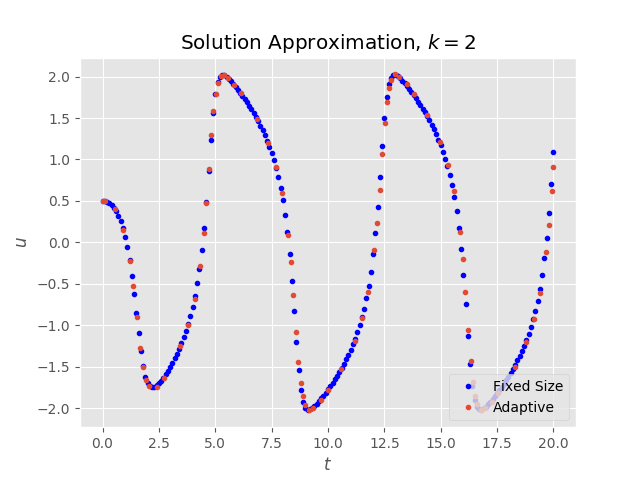

<IPython.core.display.Javascript object>


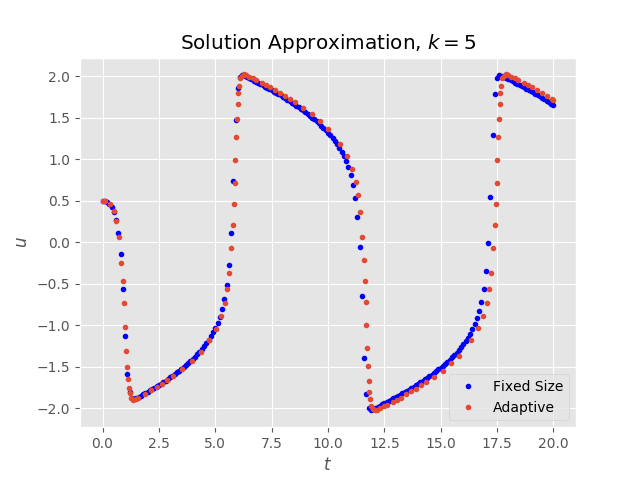

<IPython.core.display.Javascript object>


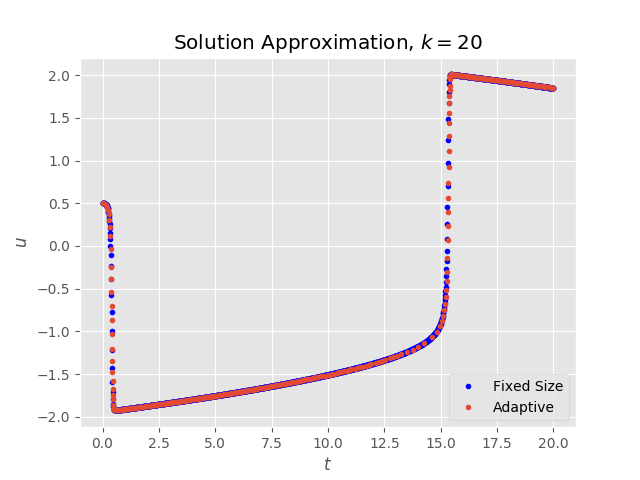

In [26]:
class hw_eqn:
    def __init__(self, k):
        self.k = k
    def f(self, t, u):
        return numpy.array([u[1], self.k * (1 - u[0] ** 2) * u[1] - u[0]])

def demo_van_der_pol(k, h0, u0, include_fixed=True):
    """
    Approximates a solution for the Van der Pol Equation with parameter k using 
    the Bogacki–Shampine method with both fixed and adaptive time step sizes, 
    then plots both.
    
    The fixed step size approximation may be disabled.
    """
    u0_local = u0.copy()
    test = hw_eqn(k)
    
    pyplot.figure()

    if include_fixed:
        hist_fixed, iter_fixed = bs3_adaptive(
            test.f, u0_local, tfinal=20, h0=h0, 
            adapt_above=False, adapt_below=False)
        times_fixed = [t for t,u,err in hist_fixed]
        pyplot.plot(times_fixed, [u[0] for t,u,err in hist_fixed], 
                    'b.', label="Fixed Size")
    
    hist_adaptive, iter_adaptive = bs3_adaptive(
        test.f, u0_local, tfinal=20, h0=h0)
    times_adaptive = [t for t,u,err in hist_adaptive]
    #pyplot.figure()
    pyplot.plot(times_adaptive, [u[0] for t,u,err in hist_adaptive], 
                '.', label="Adaptive")

    pyplot.title("Solution Approximation, $k={:d}$".format(k))
    pyplot.ylabel('$u$')
    pyplot.xlabel('$t$')
    pyplot.legend(loc='lower right')

u0 = numpy.array([0.5, 0.0])
h0 = 0.1
demo_van_der_pol(2, h0, u0)
demo_van_der_pol(5, h0, u0)
demo_van_der_pol(20, 0.01, u0)

In the $k=20$ case, using a fixed time step size requires a smaller time step $h$ than the other test cases; with the step size $h=0.1$, the approximation diverges on the steep initial descent.

In these plots, we can see the step sizes taken by the adaptive method adjust for different segments of $u$. For example, in the $k=2$ case, the steps are smallest when approaching a peak or valley, then grow for a short time afterward.

# Convergence Study

Next, we'll do a convergence study for the BS3 implementation, again using the Van der Pol equation. For this study, we'll still use the unforced equation, verifying that the integrator converges to some value as the resolution of the test grid increases.

Below is a study for BS3 with a fixed step size.

<IPython.core.display.Javascript object>


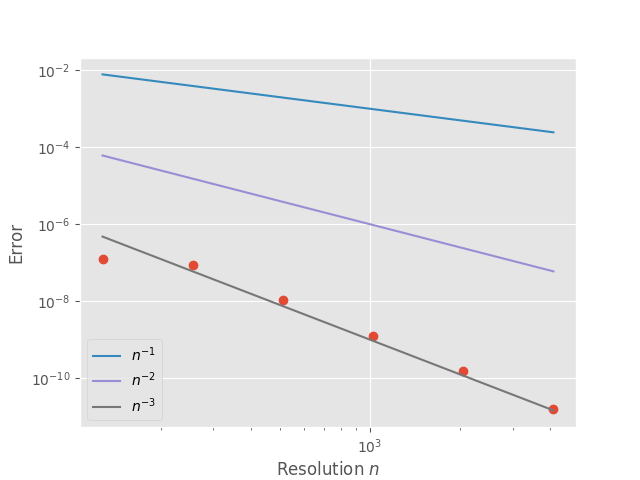

In [27]:
def vdp_convergence_study(grids, k):
    error = []
    tfinal = 20
    test = hw_eqn(k)
    u0 = numpy.array([0.5, 0.0])
    
    # Calculate the approximate solution on the finest grid
    finest_grid = grids[-1]
    finest_hist, finest_iter = bs3_adaptive(
        test.f, u0, tfinal=tfinal, h0=tfinal/finest_grid, 
        adapt_above=False, adapt_below=False)
    finest_t, finest_u, finest_err = zip(*finest_hist)    

    for n in grids[:-1]:
        # Calculate the approximate solution at this resolution
        hist, iterations = bs3_adaptive(
            test.f, u0, tfinal=tfinal, h0=tfinal/n, 
            adapt_above=False, adapt_below=False)
        t, u, err = zip(*hist)
        test_u = [u_vals[0] for u_vals in u]

        # Filter the results on the finest grid to the same time sequence
        compare_hist = []
        for point in hist:
            compare_hist.append(
                [item for item in finest_hist if item[0] == point[0]][0])
            
        compare_u = [u[0] for t,u,err in compare_hist]
        
        # Record the error between the approximation and the actual solution
        error.append(numpy.linalg.norm(
            numpy.array(test_u) - numpy.array(compare_u), 
            numpy.inf))
    return grids[:-1], error

k = 5
grids = 2 ** numpy.arange(7, 14)
ns, error = vdp_convergence_study(grids, k)
error_scaled = 10e-8 * numpy.array(error)

# Start a new figure and plot the error against comparison lines
pyplot.figure()
pyplot.loglog(ns, error_scaled, 'o')
for i in range(1, 4):
    pyplot.loglog(ns, ns ** (-1.0 * i), label="$n^{{-{:d}}}$".format(i))

pyplot.xlabel('Resolution $n$')
pyplot.ylabel('Error')
pyplot.legend(loc='lower left')

On this plot, we observe third-order convergence for the Bogacki-Shampine method with a fixed step size. Note that on the test grids with resolution $2^6$ and below ($2^6$, $2^5$, $...$), the approximation blew up.

We'll also do a quick plot in the style of a grid refinement study for the adaptive method, shown below. We'll use the solution from the fixed step size method on a fine grid as the "true" value, comparing the results of the methods for $u(t_f)$ as the error values.

<IPython.core.display.Javascript object>


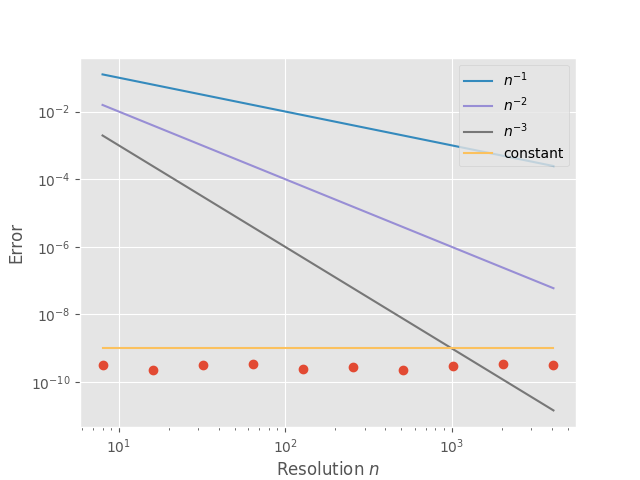

In [28]:
def vdp_convergence_study_adaptive(grids, k):
    error = []
    tfinal = 20
    test = hw_eqn(k)
    
    # Calculate the approximate solution on the finest grid
    finest_grid = grids[-1]
    finest_hist, finest_iter = bs3_adaptive(
        test.f, u0, tfinal=tfinal, h0=tfinal/finest_grid,
        adapt_above=False, adapt_below=False)    
    final_u = finest_hist[-1][1][0]

    for n in grids[:-1]:
        # Calculate the approximate solution at this resolution
        hist, iterations = bs3_adaptive(
            test.f, u0, tfinal=tfinal, h0=tfinal/n,
            adapt_above=True, adapt_below=True)
        t, u, err = zip(*hist)
        test_u = [u_vals[0] for u_vals in u]
        
        error.append(numpy.abs(final_u - test_u[-1]))

    return grids[:-1], error

k = 5
grids = 2 ** numpy.arange(3, 14)
ns, error = vdp_convergence_study_adaptive(grids, k)
error_scaled = 10e-8 * numpy.array(error)

# Start a new figure and plot the differences against comparison lines
pyplot.figure()
pyplot.loglog(ns, error_scaled, 'o')
for i in range(1, 4):
    pyplot.loglog(ns, ns ** (-1.0 * i), label="$n^{{-{:d}}}$".format(i))

pyplot.loglog(ns, 0 * ns + 10e-10, label="constant".format(i))
pyplot.xlabel('Resolution $n$')
pyplot.ylabel('Error')
pyplot.legend(loc='upper right')

With an adaptive step size, the method will adjust to maintain a consistent error level. The results of starting with different step sizes don't differ by much because similar step sizes end up being used over time.

## Work-Precision Diagrams

### Matrix Exponential

For ease of use, we'll first create a work-precision diagram for the results using the test equation $\dot u = A u$ and solution $u(t) = e^{At} u(0)$.

<IPython.core.display.Javascript object>


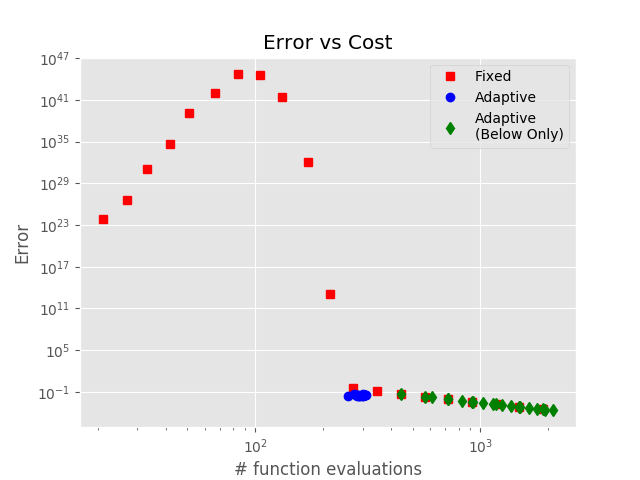

In [29]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X.dot(numpy.diag(numpy.exp(L))).dot(numpy.linalg.inv(X))

class linear:
    """
    Provides functions describing this differential equation:
      u' = Au
    with the solution function 
      u(t) = e^(At) * u(0)
    """
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A.dot(u)
    def u(self, t, u0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real(expm(self.A*s).dot(u0)) for s in t]

def mms_error(h0, adapt_above, adapt_below):
    test = linear(numpy.array([[0, 1, 0],[-1, 0, 0],[10, 0, -10]]))
    hist, iterations = bs3_adaptive(
        test.f, u0, tfinal=20, h0=h0, 
        adapt_above=adapt_above, adapt_below=adapt_below)
    times = [t for t,u,err in hist]
    u = numpy.array([u for t,u,err in hist])
    return numpy.linalg.norm(u - test.u(times, u0), numpy.inf), iterations

hs = numpy.logspace(-1.5, .5, 20)
u0 = numpy.array([.5, 0, 0])

results_fixed = [mms_error(h, False, False) for h in hs]
error_fixed, iter_fixed = zip(*results_fixed)  

results_adaptive = [mms_error(h, True, True) for h in hs]
error_adaptive, iter_adaptive = zip(*results_adaptive)

results_adaptiveB = [mms_error(h, True, False) for h in hs]
error_adaptiveB, iter_adaptiveB = zip(*results_adaptiveB)    

pyplot.figure()
pyplot.loglog(numpy.array(iter_fixed) * 3, error_fixed, 
    'sr', label='Fixed')
pyplot.loglog(numpy.array(iter_adaptive) * 3, error_adaptive, 
    'ob', label='Adaptive')
pyplot.loglog(numpy.array(iter_adaptiveB) * 3, error_adaptiveB, 
    'dg', label='Adaptive\n(Below Only)')
pyplot.title('Error vs Cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='upper right')

Above are the results for (1) the fixed step size method, (2) the method that adjusts step sizes for errors above and below the threshold, and (3) the method that adjusts step sizes for errors above the threshold only.

We can see the results for the more adaptive method cluster to similar numbers of function evaluations with similar error results. This occurs because the method adapts to both errors above and below the tolerance, so it will trend toward similar step sizes for the same problem, given time.

Using an adaptive method that only adjusts step sizes in response to estimated error exceeding the threshold creates a sequence with errors decreasing at a similar rate to the stable section of the fixed step size method, but requiring more function evaluations than the fixed step size method and the more adaptive method.

### Van der Pol Equation

Now we'll create a new work-precision diagram for the Bogacki-Shampine method with results from the Van der Pol Equation that we used for testing before. We'll use $k=5$.

Like with the "grid refinement" type of plot, we'll consider the solution approximation from a fine grid to be the actual value in the evaluation. For a simple error calculation, we'll compare the results of the approximations at the final time, $t_f$, which we know will be a time point in every solution.

<IPython.core.display.Javascript object>


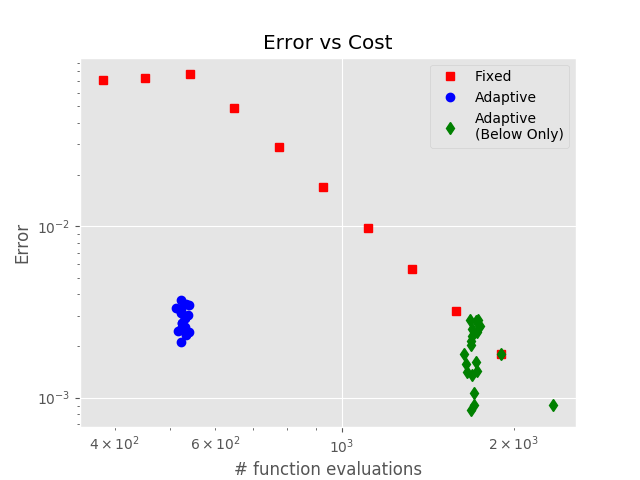

In [30]:
def error_self(k, h0, adapt_above, adapt_below):
    u0 = numpy.array([.5, 0])
    test = hw_eqn(k)
    
    # Calculate the approximate solution on a fine grid
    finest_hist, finest_iter = bs3_adaptive(
        test.f, u0, tfinal=20, h0=20/2048, adapt_above=False, adapt_below=False)    
    final_u = finest_hist[-1][1][0]
    
    # Compare the value of the test approximation at the final time to the value
    # from the fine grid approximation. This will be the 'error'
    hist, iterations = bs3_adaptive(
        test.f, u0, tfinal=20, h0=h0, 
        adapt_above=adapt_above, adapt_below=adapt_below)
    times = [t for t,u,err in hist]
    u = numpy.array([u[0] for t,u,err in hist])
    
    return numpy.abs(final_u - u[-1]), iterations

# The fixed step size method blows up for the coarser grids, so we need a
# different set of time steps for it.
hs_fixed = numpy.logspace(-1.5, -0.8, 10)
results_fixed_s = [error_self(5, h, False, False) for h in hs_fixed]
error_fixed_s, iter_fixed_s = zip(*results_fixed_s)  

hs = numpy.logspace(-1.5, .5, 20)

results_adaptive_s = [error_self(5, h, True, True) for h in hs]
error_adaptive_s, iter_adaptive_s = zip(*results_adaptive_s)

results_adaptiveB_s = [error_self(5, h, True, False) for h in hs]
error_adaptiveB_s, iter_adaptiveB_s = zip(*results_adaptiveB_s)    

pyplot.figure()
pyplot.loglog(numpy.array(iter_fixed_s) * 3, error_fixed_s, 
    'sr', label='Fixed')
pyplot.loglog(numpy.array(iter_adaptive_s) * 3, error_adaptive_s, 
    'ob', label='Adaptive')
pyplot.loglog(numpy.array(iter_adaptiveB_s) * 3, error_adaptiveB_s, 
    'dg', label='Adaptive\n(Below Only)')
pyplot.title('Error vs Cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='upper right')

This plot bears a resemblance to the one generated using the matrix exponential solution to $\dot u = A u$. We see eerror decreasing for smaller step sizes with the fixed size method and clusters for the adaptive methods. The adaptive method that does not adjust in response to smaller errors also behaves like the fixed step size method for sufficiently small initial step sizes.

The more adaptive method, which adjust step sizes for errors above and below the tolerance, provides a good balance between function evaluations and errors. Although you can achieve low errors with the fixed step size method and less adaptive method, the more adaptive method will generally perform fewer function evaluations for an acceptable error value. With this method, however, you have the least direct control over the size of the steps taken.